In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../..')
from muzero.config import make_atari_config
from muzero.continous.io import ContinousActionDecoder, ContinousActionEncoder
from muzero.continous.net import ContinousMuzeroNet, VitConfig
from muzero.gym_env import create_atari_environment
import numpy as np

In [2]:
runtime_device = "cuda"

random_state = np.random.RandomState(42)

def environment_builder():
    return create_atari_environment(
        env_name="Pong",
        screen_height=224,
        screen_width=224,
        frame_skip=4,
        frame_stack=2,
        max_episode_steps=1000,
        seed=random_state.randint(1, 2**31),
        noop_max=30,
        terminal_on_life_loss=False,
        clip_reward=False,
        output_actions=True,
        resize_and_gray=False
    )

eval_env, eval_actions = environment_builder()

config = make_atari_config(
        num_training_steps=10,
        batch_size=2,
        min_replay_size=2,
        use_tensorboard=False,
        clip_grad=True,
    )
    
formatted_actions = [f"action: {action}" for action in eval_actions]
print(f"formatted actions: {formatted_actions}")

tokenized_actions = tokenizer(formatted_actions, padding=True, return_tensors="pt").to(runtime_device)
# print(f"tokenized actions: {tokenized_actions}")
action_encoder = ContinousActionEncoder()
action_embeddings = action_encoder(tokenized_actions.input_ids, tokenized_actions.attention_mask)

print("action embeddings shape: ", action_embeddings.shape)

action_decoder = ContinousActionDecoder(action_embeddings)

network = ContinousMuzeroNet(
    action_encoder,
    action_decoder,
    action_embeddings.shape[-1],
    VitConfig(),
    config.num_planes,
    config.value_support_size,
    config.reward_support_size,
)

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
/Users/paul/dev/muzero/.venv/lib/python3.10/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/Users/paul/dev/muzero/.venv/lib/python3.10/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/Users/paul/dev/muzero/muzero/notebooks/../../muzero/gym_env.py:429: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  self.actions_mask = np.ones(num_actions, dtype=np.bool8).flatten()


formatted actions: ['action: NOOP', 'action: FIRE', 'action: RIGHT', 'action: LEFT', 'action: RIGHTFIRE', 'action: LEFTFIRE']


TypeError: SimpleTokenizer.__call__() got an unexpected keyword argument 'padding'

In [ ]:
%env PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

env: PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python


In [ ]:


import copy
import logging
import multiprocessing
from typing import Callable, Iterable, List, Optional

import gym
import torch
from muzero.config import MuZeroConfig
from muzero.mcts import uct_search
from muzero.network import MuZeroNet
from muzero.pipeline import compute_mc_return_target, compute_n_step_target, handle_exit_signal
from muzero.replay import Transition
from muzero.trackers import make_actor_trackers


def make_continous_unroll_sequence(
    observations: List[np.ndarray],
    actions: List[np.ndarray],
    rewards: List[float],
    pi_probs: List[np.ndarray],
    values: List[float],
    priorities: List[float],
    unroll_steps: int,
) -> Iterable[Transition]:
    """Turn a lists of episode history into a list of structured transition object,
    and stack unroll_steps for actions, rewards, values, MCTS policy.

    Args:
        observations: a list of history environment observations.
        actions: a list of history actual actions taken in the environment.
        rewards: a list of history reward received from the environment.
        pi_probs: a list of history policy probabilities from the MCTS search result.
        values: a list of n-step target value.
        priorities: a list of priorities for each transition.
        unroll_steps: number of unroll steps during traning.

    Returns:
        yeilds tuple of structured Transition object and the associated priority for the specific transition.

    """

    T = len(observations)

    # States past the end of games are treated as absorbing states.
    if len(actions) == T:
        actions += [0] * unroll_steps
    if len(rewards) == T:
        rewards += [0] * unroll_steps
    if len(values) == T:
        values += [0] * unroll_steps
    if len(pi_probs) == T:
        absorb_policy = np.ones_like(pi_probs[-1]) / len(pi_probs[-1])
        pi_probs += [absorb_policy] * unroll_steps

    assert len(actions) == len(rewards) == len(values) == len(pi_probs) == T + unroll_steps

    for t in range(T):
        end_index = t + unroll_steps
        action_sequence = torch.stack([action.cpu().float() for action in actions[t:end_index]])
        print(" ================= action_sequence: ", action_sequence)
        print(" ================= action_sequence shape: ", [action.shape for action in action_sequence])
        stacked_action = action_sequence.numpy()
        stacked_reward = np.array(rewards[t:end_index], dtype=np.float32)
        stacked_value = np.array(values[t:end_index], dtype=np.float32)
        stacked_pi_prob = np.array(pi_probs[t:end_index], dtype=np.float32)

        yield (
            Transition(
                state=observations[t],  # no stacking for observation, since it is only used to get initial hidden state.
                action=stacked_action,
                reward=stacked_reward,
                value=stacked_value,
                pi_prob=stacked_pi_prob,
            ),
            priorities[t],
        )
        

@torch.no_grad()
def run_self_play(
    config: MuZeroConfig,
    rank: int,
    network: MuZeroNet,
    device: torch.device,
    env: gym.Env,
    data_queue: multiprocessing.Queue,
    train_steps_counter: multiprocessing.Value,
    stop_event: multiprocessing.Event,
    tag: str = None,
    no_mask: bool = False,
    action_decoder: Optional[Callable] = None,
    action_encoder: Optional[Callable] = None,
) -> None:
    """Run self-play for as long as needed, only stop if `stop_event` is set to True.

    Args:
        config: a MuZeroConfig instance.
        rank: actor process rank.
        network: a MuZeroNet instance for acting.
        device: PyTorch runtime device.
        env: actor's env.
        data_queue: a multiprocessing.Queue instance to send samples to leaner.
        train_steps_counter: a multiprocessing.Value instance to count current training steps.
        stop_event: a multiprocessing.Event instance signals stop run pipeline.
        tag: add tag to tensorboard log dir.
    """

    handle_exit_signal()
    logging.info(f'Start self-play actor {rank}')

    tb_log_dir = f'actor{rank}'
    if tag is not None and tag != '':
        tb_log_dir = f'{tag}_{tb_log_dir}'

    trackers = make_actor_trackers(tb_log_dir) if config.use_tensorboard else []
    for tracker in trackers:
        tracker.reset()

    network = network.to(device=device)
    network.eval()
    game = 0

    while not stop_event.is_set():  # For each new game.
        obs = env.reset()
        done = False
        episode_trajectory = []
        steps = 0

        # Play and record transitions.
        # the second check is necessary becase the pipeline could have already stopped while the actor is in the middle of a game.
        while not done and not stop_event.is_set():
            # Make a copy of current player id.
            player_id = copy.deepcopy(env.current_player)
            # print(" ================= obs shape: ", obs.shape)
            action, pi_prob, root_value = uct_search(
                state=obs,
                network=network,
                device=device,
                config=config,
                temperature=config.visit_softmax_temperature_fn(steps, train_steps_counter.value),
                actions_mask=env.actions_mask,#None if no_mask else env.actions_mask,
                current_player=env.current_player,
                opponent_player=env.opponent_player,
                action_encoder=action_encoder,
            )
            
            # if action_decoder is not None:
                # action = action_decoder(action)
            # print(" ================= action: ", action)

            next_obs, reward, done, _ = env.step(action)
            steps += 1
            print (" ================= iteration: ", steps)
            if (steps % 10) == 0:
                done = True
            action = action if action_encoder is None else action_encoder(action)
            for tracker in trackers:
                tracker.step(reward, done)

            episode_trajectory.append((obs, action, reward, pi_prob, root_value, player_id))
            obs = next_obs
            
            # Send samples to learner every N steps on Atari games.
            # Here we accmulate N + unroll_steps + td_steps because
            # we needs these extra sequences to compute the target and unroll sequences.
            if (
                not config.is_board_game
                and len(episode_trajectory) == config.acc_seq_length + config.unroll_steps + config.td_steps
            ):
                # Unpack list of tuples into seperate lists.
                observations, actions, rewards, pi_probs, root_values, _ = map(list, zip(*episode_trajectory))
                # Compute n_step target value.
                target_values = compute_n_step_target(rewards, root_values, config.td_steps, config.discount)

                priorities = np.abs(np.array(root_values) - np.array(target_values))

                print(" ================= actions: ", actions[: config.acc_seq_length + config.unroll_steps])
                # Make unroll sequences and send to learner.
                for transition, priority in make_continous_unroll_sequence(
                    observations[: config.acc_seq_length],
                    actions[: config.acc_seq_length + config.unroll_steps],
                    rewards[: config.acc_seq_length + config.unroll_steps],
                    pi_probs[: config.acc_seq_length + config.unroll_steps],
                    target_values[: config.acc_seq_length + config.unroll_steps],
                    priorities[: config.acc_seq_length + config.unroll_steps],
                    config.unroll_steps,
                ):
                    shapes = {
                        "state": transition.state.shape,
                        "action": transition.action.shape,
                        "reward": transition.reward.shape,
                        "value": transition.value.shape,
                        "pi_prob": transition.pi_prob.shape,
                    }
                    print(f"Transition shapes: {shapes}")
                    data_queue.put((transition, priority))

                del episode_trajectory[: config.acc_seq_length]
                del (observations, actions, rewards, pi_probs, root_values, priorities, target_values)

        game += 1

        # Unpack list of tuples into seperate lists.
        observations, actions, rewards, pi_probs, root_values, player_ids = map(list, zip(*episode_trajectory))
        
        if config.is_board_game:
            # Using MC returns as target value.
            target_values = compute_mc_return_target(rewards, player_ids)
        else:
            # Compute n_step target value.
            target_values = compute_n_step_target(rewards, root_values, config.td_steps, config.discount)

        priorities = np.abs(np.array(root_values) - np.array(target_values))
        print(" =============== full unroll")
        # Make unroll sequences and send to learner.
        for transition, priority in make_continous_unroll_sequence(
            observations, actions, rewards, pi_probs, target_values, priorities, config.unroll_steps
        ):
            data_queue.put((transition, priority))

        del episode_trajectory[:]
        del (observations, actions, rewards, pi_probs, root_values, priorities, player_ids, target_values)

    logging.info(f'Stop self-play actor {rank}')


In [ ]:
import multiprocessing
import torch
from torch.optim.lr_scheduler import MultiStepLR
from muzero.atari_v2.run_training import ActionEncoderWith
from muzero.pipeline import run_training
from muzero.replay import PrioritizedReplay

optimizer = torch.optim.Adam(network.parameters(), lr=config.lr_init, weight_decay=config.weight_decay)
lr_scheduler = MultiStepLR(optimizer, milestones=config.lr_milestones, gamma=config.lr_decay_rate)
replay = PrioritizedReplay(
        10,
        0.0,
        0.0,
        random_state,
    )
data_queue = multiprocessing.SimpleQueue()
train_steps_counter = multiprocessing.Value('i', 0)
manager = multiprocessing.Manager()
checkpoint_files = manager.list()
stop_event = multiprocessing.Event()

action_encoder = ActionEncoderWith(action_embeddings)

run_self_play(
            config,
            0,
            network,
            runtime_device,
            eval_env,
            data_queue,
            train_steps_counter,
            stop_event,
            "tag",
            False,
            action_decoder,
            action_encoder,
            )

I0409 00:29:14.819081 31244 1644529528.py:110] Start self-play actor 0


 ================= iteration:  1
 ================= iteration:  2
 ================= iteration:  3
 ================= iteration:  4
 ================= iteration:  5
 ================= iteration:  6
 ================= iteration:  7
 ================= iteration:  8
 ================= iteration:  9
 ================= iteration:  10
 =============== full unroll
 ================= action_sequence:  tensor([[ 0.5000, -0.1348,  1.2188,  ..., -1.5156,  1.1406,  1.3828],
        [ 0.6836, -1.2031,  1.2188,  ..., -2.0156,  0.5859,  2.7500],
        [ 0.4648, -0.3516,  1.2188,  ..., -0.6562,  1.9766,  1.3828],
        [ 0.6836,  0.4941,  1.2188,  ..., -1.2031,  0.9609,  1.3828],
        [ 1.0234, -0.1973,  1.2188,  ..., -0.7070,  1.0312,  1.3828]])
 ================= action_sequence shape:  [torch.Size([2048]), torch.Size([2048]), torch.Size([2048]), torch.Size([2048]), torch.Size([2048])]


: 

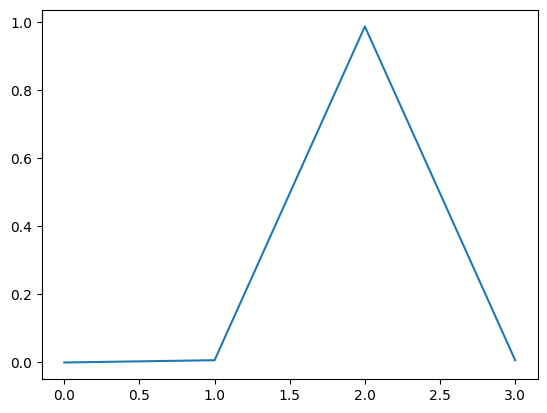

In [13]:
import torch
import matplotlib.pyplot as plt
import math

def normalized_gaussian(i: int, l: int, phi: float) -> torch.Tensor:
    # Generate an array of indices
    x = torch.arange(l)
    # Calculate the Gaussian function
    gaussian = torch.exp(-0.5 * ((x - i) / math.sqrt(phi)) ** 2)
    # Normalize the Gaussian to sum to 1
    normalized_gaussian = gaussian / torch.sum(gaussian)
    return normalized_gaussian

d = normalized_gaussian(2, 4, 0.1)
plt.plot(d)

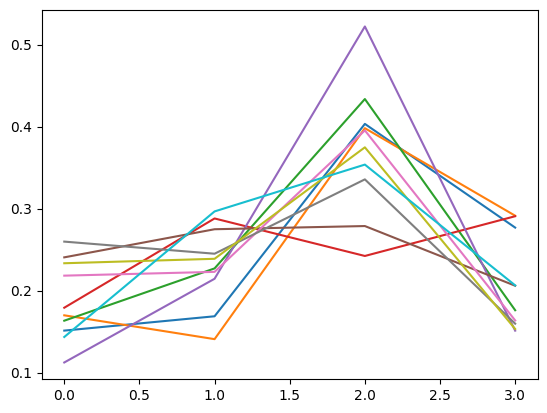

In [100]:
def normalized_uniform(i: int, l: int, temp: float) -> torch.Tensor:
    scales = torch.ones(l) * temp
    scales[i] = 1
    random_sample = torch.rand(l) * math.log(2.71828 * temp + 1) + (1 - temp)
    scaled_sample = random_sample * scales
    normalized_sample = scaled_sample / torch.sum(scaled_sample)
    return normalized_sample

for i in range(10):
    d = normalized_uniform(2, 4, 0.5)
    plt.plot(d)

plt.show()

In [70]:
math.log(2.71828)

0.999999327347282

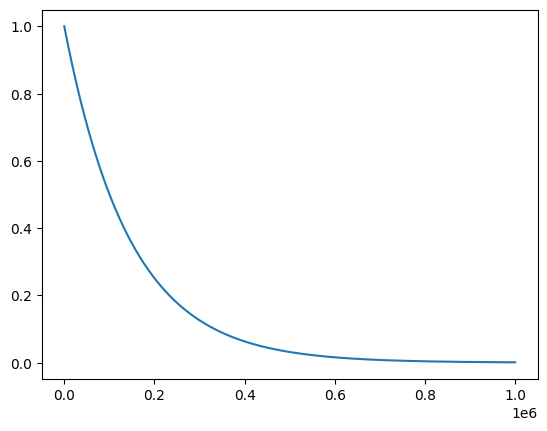

In [103]:
def continous_annealing(step: int):
    total_steps = 1e6
    return math.exp(-0.5 * math.log(total_steps) * step / total_steps)

values = [continous_annealing(i) for i in range(int(1e6))]
plt.plot(values)

In [91]:
math.sqrt(10e6)

3162.2776601683795

In [17]:
import numpy as np


a = np.random.rand(20, 128)

In [ ]:
q = np.random.rand(5, 128)

In [ ]:
sims = np.einsum('ik, jk -> ij', a, q)

In [3]:
len(np.max(sims, axis=-1).tolist())

NameError: name 'sims' is not defined

In [4]:
import torch
from typing import Callable

BATCH_SIZE = 10
FEATURE_IN = 15
FEATURE_HIDDEN = 20
FEATURE_OUT = 5

X = torch.rand(BATCH_SIZE, FEATURE_IN)
W1 = torch.rand(FEATURE_IN, FEATURE_HIDDEN)
W2 = torch.rand(FEATURE_HIDDEN, FEATURE_OUT)

relu: Callable[[torch.Tensor], torch.Tensor] = lambda x: torch.maximum(torch.zeros_like(x), x)

L1 = torch.einsum('bi, ik -> bk', X, W1)
print(L1.shape)
Y = relu(L1)
L2 = torch.einsum('kl, lm -> km', Y, W2)
print(L2.shape)

torch.Size([10, 20])
torch.Size([10, 5])


In [5]:
L2

tensor([[44.9728, 51.2455, 41.0634, 47.6049, 51.1049],
        [34.4813, 39.3794, 33.2365, 37.8387, 40.4970],
        [45.8747, 52.1951, 41.3250, 49.0369, 51.1205],
        [24.7668, 28.1200, 21.6890, 26.4771, 27.7048],
        [34.7036, 40.4682, 33.4993, 38.4275, 40.8574],
        [37.2981, 41.4486, 33.1060, 39.6377, 42.1140],
        [39.5917, 45.3085, 36.5566, 42.5559, 44.1063],
        [38.2524, 43.8538, 35.4368, 41.8323, 43.5950],
        [36.8876, 42.3559, 33.9741, 40.5927, 41.7260],
        [29.0999, 32.9907, 26.5787, 31.2052, 33.2041]])

In [6]:
import torch
import torch.nn.functional as F
import math

BATCH_SIZE = 10
SEQ_LEN = 20
FEATURES = 64

# Input matrix X
X = torch.rand(BATCH_SIZE, SEQ_LEN, FEATURES)

# Weight matrices
W_q = torch.rand(FEATURES, FEATURES)
W_k = torch.rand(FEATURES, FEATURES)
W_v = torch.rand(FEATURES, FEATURES)

sqrt_d = math.sqrt(FEATURES)
softmax: Callable[[torch.Tensor], torch.Tensor] = lambda z: torch.exp(z) / torch.sum(torch.exp(z), dim=-1).unsqueeze(-1)

# Compute Query, Key, and Value projections: Given an input matrix X shaped (batch_size, seq_len, features),
# compute the query, key, and value matrices using separate weight matrices W_q, W_k, and W_v respectively.
# Each weight matrix is shaped (features, features). This will involve three separate matrix multiplications.

P_q = torch.einsum('bsm, mk -> bsk', X, W_q)
P_k = torch.einsum('bsm, mk -> bsk', X, W_k)
P_v = torch.einsum('bsm, mk -> bsk', X, W_v)

print(P_q.shape)
print(P_k.shape)
print(P_v.shape)

# Compute the Attention Scores: Calculate the attention scores by taking the dot product of queries and keys,
# and then apply scaling by the square root of the number of feature dimensions.
QT = torch.einsum('bsk -> bks', P_q)
QK = torch.einsum('bjs, bsk -> bjk', QT, P_k) # matrix multiply
# The resulting scores should be shaped (batch_size, seq_len, seq_len).
# Apply Softmax: Apply the softmax function across each row of the attention scores to normalize them.
print(QK.shape)
A = softmax(QK / sqrt_d)
A.shape
# Weighted Sum of Values: Use the normalized attention scores to compute a weighted sum of the values.
V = torch.einsum('bjk, bsk -> bsk', A, P_v)


torch.Size([10, 20, 64])
torch.Size([10, 20, 64])
torch.Size([10, 20, 64])
torch.Size([10, 64, 64])


In [136]:
V.shape

torch.Size([10, 20, 64])

In [105]:
z = torch.rand(4, 16)
print(z)
softmax: Callable[[torch.Tensor], torch.Tensor] = lambda z: torch.exp(z) / torch.sum(torch.exp(z), dim=-1).unsqueeze(-1)

y = softmax(z)

tensor([[0.6635, 0.4235, 0.1549, 0.1084, 0.8744, 0.0948, 0.9314, 0.6988, 0.2114,
         0.2297, 0.2112, 0.7232, 0.9971, 0.6689, 0.3321, 0.7196],
        [0.9258, 0.7788, 0.6970, 0.9834, 0.9905, 0.0980, 0.4416, 0.6862, 0.4453,
         0.6187, 0.3885, 0.8789, 0.8337, 0.9387, 0.9999, 0.4996],
        [0.3644, 0.1814, 0.9756, 0.0173, 0.1563, 0.9742, 0.9817, 0.8408, 0.5952,
         0.0949, 0.0720, 0.2024, 0.6401, 0.1854, 0.0862, 0.1092],
        [0.3694, 0.8715, 0.4646, 0.1043, 0.0541, 0.2567, 0.6724, 0.4861, 0.7344,
         0.9440, 0.1602, 0.1917, 0.2132, 0.8115, 0.0479, 0.7009]])


In [106]:
y.shape

torch.Size([4, 16])

In [107]:
torch.sum(y, dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000])

In [138]:
import torch
import torch.nn.functional as F

BATCH_SIZE = 10
SEQ_LEN = 20
FEATURES = 64

# Input matrix X
X = torch.rand(BATCH_SIZE, SEQ_LEN, FEATURES)

# Weight matrices
W_q = torch.rand(FEATURES, FEATURES)
W_k = torch.rand(FEATURES, FEATURES)
W_v = torch.rand(FEATURES, FEATURES)

# Compute Query, Key, Value matrices
Q = torch.einsum('bsf, fh -> bsh', X, W_q)  # Replace 'h' with the appropriate dimension if different
K = torch.einsum('bsf, fh -> bsh', X, W_k)
V = torch.einsum('bsf, fh -> bsh', X, W_v)

# Compute Attention Scores
scores = torch.einsum('bsh, bth -> bst', Q, K) / (FEATURES ** 0.5)

# Apply Softmax
scores_normalized = F.softmax(scores, dim=-1)

# Weighted Sum of Values
output = torch.einsum('bst, bsh -> bth', scores_normalized, V)

# Output of the self-attention mechanism
print(output.shape)  # Should be (BATCH_SIZE, SEQ_LEN, FEATURES)

torch.Size([10, 20, 64])


In [3]:
import torch

example = torch.ones(4)

In [4]:
def add_gaussian_noise(value: np.ndarray, sigma: float = 0.03) -> np.ndarray:
    """Add gaussian noise to a given value.
    Args:
        value: a numpy.array contains value we want to add noise to.
        sigma: standard deviation of the gaussian noise.

    Returns:
        value with added gaussian noise.

    Raises:
        ValueError:
            if input argument `value` is not a valid float numpy.array.
            if input argument `sigma` is not float type.
    """

    if not isinstance(value, np.ndarray) or value.dtype not in (np.float32, np.float64):
        raise ValueError(f"Expect `value` to be a numpy.array, got {value}")
    if not isinstance(sigma, float):
        raise ValueError(f"Expect `sigma` to be float type, got {sigma}")

    noise = np.random.normal(0, sigma, value.shape)
    return value + noise

In [5]:
from matplotlib import pyplot as plt

plt.plot(example)

NameError: name 'plt' is not defined